Qucik check for which proteases would be best at detecting NLS. These are very R and K-rich (this is how they are defined!) so not detectable in tryptic digests.

In [119]:
import urllib3
import json
import requests, sys
import collections
import re
import proteomics.sequence as sequence
from time import gmtime, strftime
import importlib
import pandas as pd

%load_ext rpy2.ipython

In [102]:
importlib.reload(sequence)

<module 'proteomics.sequence' from '/home/FILESERVER5/proteomics/tss38/git_repos/CamProt/proteomics/sequence.py'>

In [93]:
url = 'https://www.ebi.ac.uk/proteins/api/features?size=10000&taxid=10090&categories=DOMAINS_AND_SITES&types=MOTIF&reviewed=true'
r = requests.get(url, headers={ "Accept" : "application/json"})

In [94]:
text = json.loads(r.text)

In [95]:
nls_blocks = collections.defaultdict(list)

r = requests.get(url, headers={ "Accept" : "application/json"})
text = json.loads(r.text)
for p_ix in text:
    for motif in p_ix['features']:
        if 'Nuclear localization signal' in motif['description']:
            nls_blocks[p_ix['accession']].append((int(motif['begin']), int(motif['end'])))

In [149]:
complete_nls = collections.defaultdict(lambda: collections.Counter())
not_complete_nls = collections.defaultdict(lambda: collections.Counter())
nls_k_covered = collections.defaultdict(lambda: collections.Counter())
nls_k_missed = collections.defaultdict(lambda: collections.Counter())
k_covered = collections.defaultdict(lambda: collections.Counter())
k_missed = collections.defaultdict(lambda: collections.Counter())


n = 0

for x in nls_blocks:
    n += 1
    if n % 100 == 0:
        print('proteins done: %i %s' % (
                n, strftime("%Y-%m-%d %H:%M:%S", gmtime())))
    #if n > 10:
    #    break
    #print("-----")
    #print(x, nls_blocks[x])
    seq, method = sequence.getSequence(x)
    k_protein_positions = set([ix + 1 for ix, base in enumerate(seq) if base == "K"])
    k_protein_positions_covered = set()
    
    for protease in ['trypsin', 'gluc', 'chromotrypsin']:
        for missed in range(0,5):
            peptides = sequence.iteratePeptides(seq, method=protease, missed_cleavages=missed)

            for peptide in peptides:
                peptide, start, end, missed = peptide

                k_peptide_positions = set(
                    [start + ix + 1 for ix, base in enumerate(peptide) if base == "K"])
                k_protein_positions_covered.update(
                    k_protein_positions.intersection(k_peptide_positions))

            k_covered[missed][protease] += len(k_protein_positions_covered)
            k_missed[missed][protease] += len(k_protein_positions.difference(k_protein_positions_covered))

            
            for block in nls_blocks[x]:
                peptides = sequence.iteratePeptides(seq, method=protease, missed_cleavages=missed)
                block_start = block[0] - 1
                block_end = block[1]
                k_nls_positions = set(
                    [block_start + ix + 1 for ix, base in
                     enumerate(seq[block_start:block_end]) if base == "K"])

                #if x == 'Q14118':
                #    print(block)
                #    print(seq[block_start:block_end])
                #    print(k_nls_positions)
                k_positions_covered = set()
                complete = False
                for peptide in peptides:
                    peptide, start, end, missed = peptide

                    if end < block_start:
                        continue

                    if start > block_end:
                        break

                    complete = False
                    if start < block_start and end > block_end:
                        complete = True
                        k_positions_covered = k_nls_positions
                        break

                    #if x == 'Q14118':
                    #    print(peptide, start, end, missed)

                    k_peptide_positions = set(
                        [start + ix + 1 for ix, base in enumerate(peptide) if base == "K"])
                    k_positions_covered.update(k_nls_positions.intersection(k_peptide_positions))
                    if len(k_nls_positions.difference(k_positions_covered)) == 0:
                        break
                #if x == 'Q14118':
                #    print(k_nls_positions, k_positions_covered)
                
                if complete:
                    complete_nls[missed][protease] += 1
                else:
                    not_complete_nls[missed][protease] += 1
                nls_k_covered[missed][protease] += len(k_positions_covered)
                nls_k_missed[missed][protease] += len(k_nls_positions.difference(k_positions_covered))
    
print(complete_nls, k_covered, k_missed, nls_k_covered, nls_k_missed)
print(n)

proteins done: 100 2017-03-17 10:51:55
proteins done: 200 2017-03-17 10:52:06
proteins done: 300 2017-03-17 10:52:19
defaultdict(<function <lambda> at 0x7f740694d6a8>, {0: Counter({'gluc': 794, 'chromotrypsin': 110, 'trypsin': 10}), 1: Counter({'gluc': 293, 'chromotrypsin': 127, 'trypsin': 4}), 2: Counter({'gluc': 82, 'chromotrypsin': 33, 'trypsin': 4}), 3: Counter({'gluc': 23, 'chromotrypsin': 5, 'trypsin': 1}), 4: Counter({'gluc': 5})}) defaultdict(<function <lambda> at 0x7f740f968ea0>, {0: Counter({'chromotrypsin': 56303, 'gluc': 51740, 'trypsin': 40485}), 1: Counter({'gluc': 24252, 'trypsin': 22833, 'chromotrypsin': 21569}), 2: Counter({'trypsin': 9015, 'gluc': 7301, 'chromotrypsin': 6683}), 3: Counter({'trypsin': 3530, 'gluc': 3130, 'chromotrypsin': 2274}), 4: Counter({'trypsin': 879, 'gluc': 651, 'chromotrypsin': 340})}) defaultdict(<function <lambda> at 0x7f743c72b1e0>, {0: Counter({'trypsin': 9499, 'gluc': 149, 'chromotrypsin': 100}), 1: Counter({'trypsin': 919, 'gluc': 79, 'ch

In [150]:
print(complete_nls)
print(k_covered)
print(k_missed)
print(nls_k_covered)
print(nls_k_missed)
print(n)

defaultdict(<function <lambda> at 0x7f740694d6a8>, {0: Counter({'gluc': 794, 'chromotrypsin': 110, 'trypsin': 10}), 1: Counter({'gluc': 293, 'chromotrypsin': 127, 'trypsin': 4}), 2: Counter({'gluc': 82, 'chromotrypsin': 33, 'trypsin': 4}), 3: Counter({'gluc': 23, 'chromotrypsin': 5, 'trypsin': 1}), 4: Counter({'gluc': 5})})
defaultdict(<function <lambda> at 0x7f740f968ea0>, {0: Counter({'chromotrypsin': 56303, 'gluc': 51740, 'trypsin': 40485}), 1: Counter({'gluc': 24252, 'trypsin': 22833, 'chromotrypsin': 21569}), 2: Counter({'trypsin': 9015, 'gluc': 7301, 'chromotrypsin': 6683}), 3: Counter({'trypsin': 3530, 'gluc': 3130, 'chromotrypsin': 2274}), 4: Counter({'trypsin': 879, 'gluc': 651, 'chromotrypsin': 340})})
defaultdict(<function <lambda> at 0x7f743c72b1e0>, {0: Counter({'trypsin': 9499, 'gluc': 149, 'chromotrypsin': 100}), 1: Counter({'trypsin': 919, 'gluc': 79, 'chromotrypsin': 46}), 2: Counter({'trypsin': 122, 'gluc': 8, 'chromotrypsin': 2}), 3: Counter({'trypsin': 31, 'gluc': 8

In [154]:
missed_cleavages = []
proteases = []
complete = []
not_complete = []
covered = []
not_covered = []
nls_covered = []
nls_not_covered = []
for missed in complete_nls:
    for protease in complete_nls[misssed]:
        missed_cleavages.append(missed)
        proteases.append(protease)
        complete.append(complete_nls[missed][protease])
        not_complete.append(not_complete_nls[missed][protease])
        covered.append(k_covered[missed][protease])
        not_covered.append(k_missed[missed][protease])
        nls_covered.append(nls_k_covered[missed][protease])
        nls_not_covered.append(nls_k_missed[missed][protease])


print(missed_cleavages, protease, complete, covered, not_covered)

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4] chromotrypsin [10, 794, 110, 4, 293, 127, 4, 82, 33, 1, 23, 5, 0, 5, 0] [40485, 51740, 56303, 22833, 24252, 21569, 9015, 7301, 6683, 3530, 3130, 2274, 879, 651, 340] [9499, 149, 100, 919, 79, 46, 122, 8, 2, 31, 8, 3, 7, 2, 0]


In [157]:
df = pd.DataFrame({'missed': missed_cleavages, 'proteases': proteases,
                   'complete': complete, 'not_complete': not_complete,
                   'nls_covered': nls_covered, 'nls_not_covered': nls_not_covered,
                   'covered': covered, 'not_covered': not_covered})

df['fraction_covered'] = 1.0 * df['covered'] / (df['covered'] + df['not_covered'])
df['fraction_complete'] = 1.0 * df['complete'] / (df['complete'] + df['not_complete'])
df['fraction_nls_covered'] = 1.0 * df['nls_covered'] / (df['nls_covered'] + df['nls_not_covered'])


print(df)

    complete  covered  missed  nls_covered  nls_not_covered  not_complete  \
0         10    40485       0         1176             3493          1500   
1        794    51740       0         4192              490           802   
2        110    56303       0         3570             1301          1498   
3          4    22833       1          790              292           439   
4        293    24252       1         1333              187           212   
5        127    21569       1         1369               93           389   
6          4     9015       2          558               15           191   
7         82     7301       2          269               35            25   
8         33     6683       2          222                2            62   
9          1     3530       3          217                3            76   
10        23     3130       3           84                0             7   
11         5     2274       3           54                1            19   

   complete covered missed nls_covered nls_not_covered not_complete not_covered
0        10   40485      0        1176            3493         1500        9499
1       794   51740      0        4192             490          802         149
2       110   56303      0        3570            1301         1498         100
3         4   22833      1         790             292          439         919
4       293   24252      1        1333             187          212          79
5       127   21569      1        1369              93          389          46
6         4    9015      2         558              15          191         122
7        82    7301      2         269              35           25           8
8        33    6683      2         222               2           62           2
9         1    3530      3         217               3           76          31
10       23    3130      3          84               0            7           8
11        5    2274      3          54  

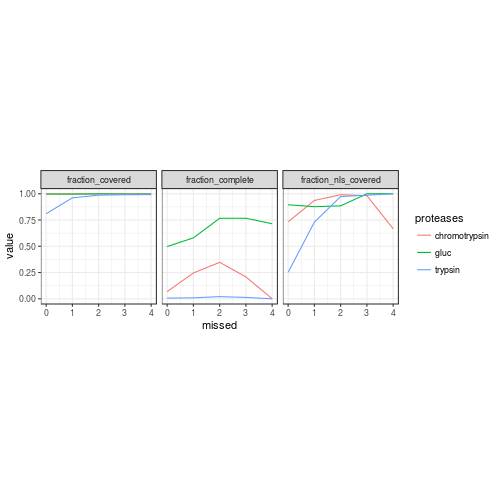

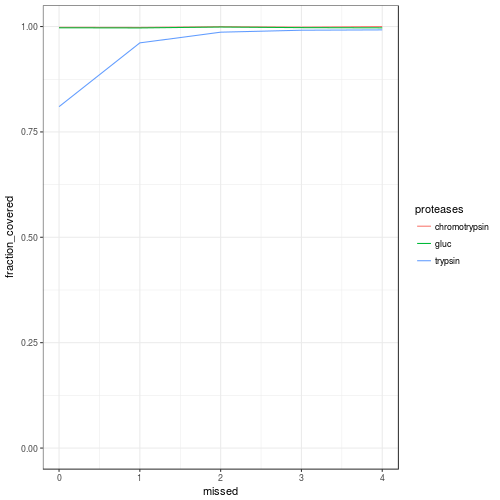

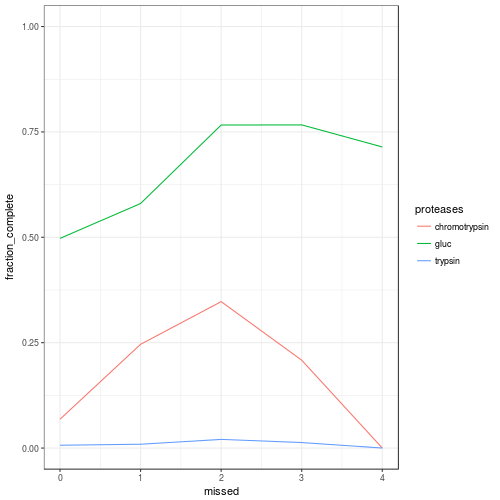

In [160]:
%%R -i df -w 500 -h 500
library(ggplot2)
library(reshape2)

print(df)

df_melt = melt(df, id=c("complete", "covered", "missed",
                        "not_complete", "not_covered",
                        "nls_not_covered", "nls_covered",
                        "proteases"))

print(df_melt)

p = ggplot(df_melt, aes(missed, value, colour=proteases)) +
geom_line() +
ylim(0,1) +
facet_wrap(~variable) +
theme_bw() +
theme(aspect.ratio=1)

print(p)

p = ggplot(df, aes(missed, fraction_covered, colour=proteases)) +
geom_line() +
ylim(0,1) +
theme_bw()

print(p)

p = ggplot(df, aes(missed, fraction_complete, colour=proteases)) +
geom_line() +
ylim(0,1) +
theme_bw()

print(p)